I am practicing the exercise from this [link](https://www.learnpytorch.io/03_pytorch_computer_vision/#exercises)

In [1]:
# check for gpu
!nvidia-smi

Sun Feb  9 17:12:42 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti     Off | 00000000:01:00.0  On |                  N/A |
| N/A   42C    P5              N/A / ERR! |     47MiB /  4096MiB |     16%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch

print(torch.__version__)

2.5.1


In [3]:
# Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device


'cuda'

## Load the torchvision.datasets.MNIST() train and test datasets.

In [7]:
from torchvision import datasets
from torchvision import transforms

# Get the MNIST train dataset
train_data = datasets.MNIST(root='data', 
                            train=True, 
                            download=True, 
                            transform=transforms.ToTensor(), 
                            target_transform=None)
# Get the MNIST test dataset
test_data = datasets.MNIST(root='data', 
                           train=False, 
                           download=True, 
                           transform=transforms.ToTensor(), 
                           target_transform=None)

In [8]:
len(train_data), len(test_data)

(60000, 10000)

In [9]:
# See the image shape and label of the data
image, label = train_data[0]

print(f"Image Shape: {image.shape}\n")
print(f"Label: {label}")

Image Shape: torch.Size([1, 28, 28])

Label: 5


In [15]:
# Get the class name
class_names = train_data.classes
print(f'Class Names: {class_names}\n')

# Get the labels idx
class_names_idx = train_data.class_to_idx
print(f"Index of the labels:\n {class_names_idx}")

Class Names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

Index of the labels:
 {'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}


## Visualize at least 9 different samples of the MNIST training dataset.

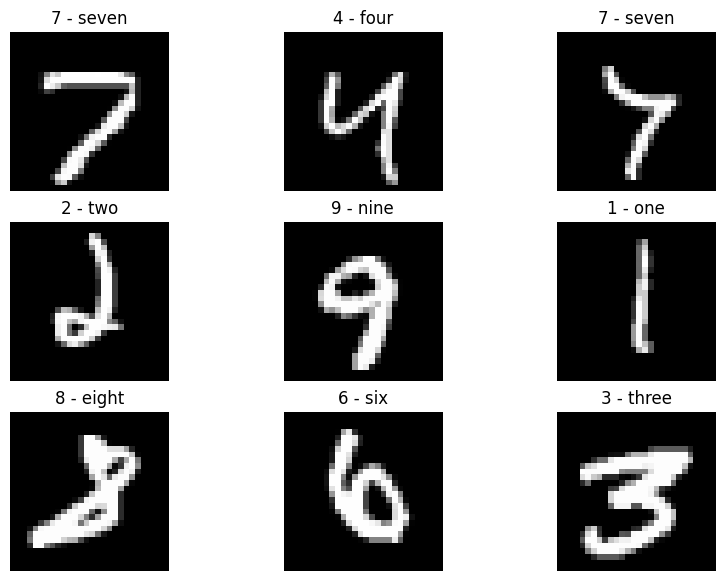

In [26]:
import matplotlib.pyplot as plt

nrows = 3
ncols = 3
fig = plt.figure(figsize=(10,7))
for i in range(1,nrows*ncols+1):
    # set random image
    random_idx = torch.randint(low=0, high=len(train_data), size=[1]).item()
    fig.add_subplot(nrows, ncols, i)
    img, label = train_data[random_idx]
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)
plt.show() 


## Turn the MNIST train and test datasets into dataloaders using torch.utils.data.DataLoader, set the batch_size=32.

In [29]:
from torch.utils.data import DataLoader

# Set the batch sizes 32 (i.e. in one batch we have 32 images)
BATCH_SIZES = 32

# Create train dataloader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZES, 
                              shuffle=True)
# Create test dataloader
test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZES, 
                             shuffle=False)

# see what we have created
print(f"Length of train dataloaders: {len(train_dataloader)} batchs of {BATCH_SIZES}")
print(f"Length of test dataloaders: {len(test_dataloader)} batchs of {BATCH_SIZES}")

Length of train dataloaders: 1875 batchs of 32
Length of test dataloaders: 313 batchs of 32


## Recreate model_2 used in notebook 03 (the same model from the CNN Explainer website, also known as TinyVGG) capable of fitting on the MNIST dataset.

In [40]:
from torch import nn
class MNISTMODELV1(nn.Module):
    """Model that capable of predicting MNIST dataset
    """

    def __init__(self, input_shape: int, hidden_unit: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_unit, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_unit*7*7, out_features=output_shape)
        )

    def forward(self,x):
        x = self.conv_block_1(x)
        # print(f"after conv block 1: {x.shape}")
        x = self.conv_block_2(x)
        # print(f"after conv block 2: {x.shape}")
        x = self.classifier(x)
        # print(f"after classifier: {x.shape}")
        return x

        
# create model instance and target to device
model_1 = MNISTMODELV1(input_shape=1, 
                       hidden_unit=10, 
                       output_shape=len(class_names)).to(device)
